In [1]:
# Reference: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
conf = tf.ConfigProto(gpu_options=opts)
tf.enable_eager_execution(config=conf)

/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lling086/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
# Reference: https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation
# https://rare-technologies.com/word2vec-tutorial/
# Local: pip install gensim
# GCP: conda install gensim (pip instal didn't work)
import random
import sys
import os
import re
import numpy as np
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, CuDNNLSTM, Input, Concatenate
import gensim
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# dir_split = f"../1.DataPreparationResults/obama"
# file_train = open(f"{dir_split}/train.txt", 'r').read()
# file_val = open(f"{dir_split}/val.txt", 'r').read()
# file_test = open(f"{dir_split}/test.txt", 'r').read()

# Windows ONLY
# dir_split = r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\1.DataPreparationResults\obama"
# file_train = open(f"{dir_split}\\train.txt", 'r').read()
# file_val = open(f"{dir_split}\\val.txt", 'r').read()
# file_test = open(f"{dir_split}\\test.txt", 'r').read()

In [5]:
rootdir = f"../1.DataPreparationResults"
files_train_lst = []
files_val_lst = []
files_test_lst = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'train.txt' in file:
            files_train_lst.append(os.path.join(subdir, file))
        elif 'val.txt' in file:
            files_val_lst.append(os.path.join(subdir, file))
        else:
            files_test_lst.append(os.path.join(subdir, file))

In [6]:
# file_train = open(f"{files_train_lst[0]}", 'r').read()
# file_val = open(f"{files_val_lst[0]}", 'r').read()
# file_test = open(f"{files_test_lst[0]}", 'r').read()

In [7]:
x_len = 30
x_step = 1

In [8]:
# os.path.exists(u"gs://w266-final-project/GoogleNews-vectors-negative300.bin")
os.path.exists("../../test/GoogleNews-vectors-negative300.bin")

True

In [9]:
# Google pre-trained word2vec model
# Reference: https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
# Reference: https://code.google.com/archive/p/word2vec/
# google_word_model = gensim.models.KeyedVectors.load_word2vec_format(r"D:\UCBerkeley\CourseWork\201909\W266\GitHub\FinalProject-Collab\GoogleNews-vectors-negative300.bin", binary=True)

google_word_model = gensim.models.KeyedVectors.load_word2vec_format('../../test/GoogleNews-vectors-negative300.bin', binary=True)
pretrained_weights = google_word_model.wv.vectors
print(type(pretrained_weights))
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

<class 'numpy.ndarray'>
Result embedding shape: (3000000, 300)


/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [10]:
def word2idx(word):
    return google_word_model.wv.vocab[word].index
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return google_word_model.wv.index2word[idx]

vocab = google_word_model.wv.vocab
# Confirm that word_model works
# print(word_model.wv.vocab["doubts"].index)

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [11]:
# The following output is too large, which will make the notebook render super slowly
# for word in vocab:
#     if '_' in word:
#         print(word)

* Google pretrained words don't include 3 common stop words: 'a', 'and', 'of', and 'to'. Interestingly, it includes 'A', 'And', 'Of', and 'To'.  
* Google pretrained model assumes all digits are replaced by #.  
* Google combines common phrases with '_' (TO BE IMPLEMENTED)

In [12]:
def google_preprocess(file):
    # e.g., there is no harrison train.txt
    if len(file) != 0:
        file2 = re.sub('\d', '#', file)
        file2 = re.sub(' a ', ' A ', file2)
        file2 = re.sub(' and ', ' And ', file2)
        file2 = re.sub(' of ', ' Of ', file2)
        file2 = re.sub(' to ', ' To ', file2)
        file2 = re.sub(' , ', ' . ', file2)
        # Add spaces around <speech_sep>
        # Create a set of all words in file.txt but remove <speech_sep>
        unique_words = set(file2.replace("<speech_sep>", " <speech_sep> ").split())
        unique_words.remove("<speech_sep>")
        return file2, unique_words
    else:
        return file, set()

In [13]:
# file_train_google, unique_words_train = google_preprocess(file_train)
# file_val_google, unique_words_val = google_preprocess(file_val)
# file_test_google, unique_words_test = google_preprocess(file_test)

In [14]:
def file_to_sentences(file, sentences):
    sentences2 = []
    next_words = []
    list_words = []
    
    for speech in file.split("<speech_sep>"):
        list_words = speech.split()
        # I noticed the last speech has zero word 
        # because <speech_sep> is the last character
        if len(list_words) == 0:
            break
        
        # each row should have x_len + 1 (both input and target)
        for i in range(0,len(list_words)-x_len-1, x_step):
            sentences2 = [word for word in list_words[i: i + x_len + 1]]
            sentences.append(sentences2)
            
    return sentences

# train_sentences = file_to_sentences(file_train_google, [])

In [15]:
def multiple_google_preprocess_to_file(files_lst):
    unique_words_lst = []
    sentences = []

    for i in range(len(files_lst)):
    #     vars()["file_google_"+str(i)], vars()["unique_words_"+str(i)] = google_preprocess(open(f"{files_lst[i]}", 'r').read())
        file_google_i, vars()["unique_words_"+str(i)] = google_preprocess(open(f"{files_lst[i]}", 'r').read())
        sentences = file_to_sentences(file_google_i, sentences)
        unique_words_lst.append(vars()["unique_words_"+str(i)])

    unique_words_set = frozenset().union(*unique_words_lst)
    
    return sentences, unique_words_set

In [16]:
sentences_train, unique_words_train = multiple_google_preprocess_to_file(files_train_lst)
sentences_val, unique_words_val = multiple_google_preprocess_to_file(files_val_lst)
sentences_test, unique_words_test = multiple_google_preprocess_to_file(files_test_lst)

In [17]:
unique_words_all = unique_words_train.union(unique_words_val.union(unique_words_test))
print("total number of unique words: ",len(unique_words_all))

total number of unique words:  38013


In [18]:
pretrained_weights_mini = []
vocab_mini_lst = []
vocab_mini_dict = dict()

# index 0: unknown words => </s>
pretrained_weights_mini.append(pretrained_weights[0])
vocab_mini_lst.append(google_word_model.wv.index2word[0])
vocab_mini_dict[google_word_model.wv.index2word[0]] = 0

# index 1: , or . => np.zeros
pretrained_weights_mini.append(np.zeros((300)))
vocab_mini_lst.append('.')
vocab_mini_dict['.'] = 1

# index 2+
i = 2
for word in unique_words_all:
    if word in google_word_model.wv.vocab:
        pretrained_weights_mini.append(pretrained_weights[google_word_model.wv.vocab[word].index])
        vocab_mini_lst.append(word)
        vocab_mini_dict[word] = i
        i += 1        

pretrained_weights_mini = np.array(pretrained_weights_mini)
print(pretrained_weights_mini.shape)
vocab_size, emdedding_size = pretrained_weights_mini.shape
print(len(vocab_mini_lst))

def word2idx(word):
    return vocab_mini_dict[word]
    # The code below works but is too slow when executing sentences_to_2darray
    # vocab_mini_lst.index(word)
    
# def word2idx(word):
#     if word in google_word_model.wv.vocab:
#         return google_word_model.wv.vocab[word].index
#     # Capitalization matters in Google trained word2vec
#     # "united" is not equal to "United"
#     elif type(word[0]) == str:
#         word = word[0].lower() + word[1:]
#         if word in google_word_model.wv.vocab:
#             return google_word_model.wv.vocab[word].index
#     else:
#         return -1
def idx2word(idx):
    return vocab_mini_lst[idx]

/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/lling086/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(35822, 300)
35822


In [19]:
def sentences_to_2darray(sentences):
    
    missing_words = set()
    
    x = np.zeros([len(sentences), x_len], dtype=np.int32)
    y = np.zeros([len(sentences)], dtype=np.int32)
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence[:-1]):
            x[i, t] = vocab_mini_dict.get(word, 0)
            if x[i, t] == 0:
                missing_words.add(word)
        y[i] = vocab_mini_dict.get(sentence[-1], 0)
        if y[i] == 0:
            missing_words.add(sentence[-1])
    print(missing_words) 
        
    return x, y

In [ ]:
train_X, train_Y = sentences_to_2darray(sentences_train)
print('train_X shape:', train_X.shape)
print('train_Y shape:', train_Y.shape)

In [20]:
val_X, val_Y = sentences_to_2darray(sentences_val)
print(val_X.shape)
print(val_Y.shape)

{'endeavour', 'gospod', 'Drugpusher', 'secured##', 'Antilies', 'Logunov', 'rivalled', 'succors', 'apprize', 'undelegated', 'niggardliness', 'waketh', 'statedly', 'Covode', 'cablegrams', 'adaptabilities', 'Eluefields', 'Tamatav', '###Foreign', 'IMy', 'recognised', 'thereof##', 'cloathing', 'SDThe', 'reenforcement', '##From', 'l#y', 'labours', 'IWe', 'Alhajuela', 'TACNA', 'Haytian', 'dejaremos', 'honour', 'exorbitancy', 'SEATrecommended', 'GYNwho', 'to#the', 'Kigara', 'revealment', 'unpitying', 'Tagalo', 'recoined', 'fulfil', 'enquiry', 'criticises', 'forbore', 'bulletined', 'SDWell', 'appropria', 'STATEAgreeably', 'Commodious', 'Esqr', 'defrayment', 'officering', 'Chinghai', 'Chindblom', 'heartburnings', 'coinsThe', 'Regencies', 'Whereof', 'VOUR', 'nonimportation', 'inwrought', 'programme', 'Spirituous', 'Borlaugs', 'Truongs', 'Olosenga', 'Fuchau', 'AIDsenior', 'DEthe', 'ISPACE', 'outpayments', 'favoured', '###Total', 'VARILLA', 'knolege', 'ningn', 'Ofoo', 'i#go', 'unsurrendered', 'poul

In [51]:
# Monitor the GPU memory usage: nvidia-smi

model = keras.Sequential()

# Reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/layers/embeddings.py
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights_mini],trainable=False))
# Reference: https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
#     The input of the LSTM is always is a 3D array. (batch_size, time_steps, seq_len)
#     The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
#     If return_sequence is False, the output is a 2D array. (batch_size, units)
#     If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)
# My guess is that the input of the dense layer has to be a 2D array
model.add(LSTM(units = 256, return_sequences = True))
model.add(LSTM(units = 256))
# model.add(Dropout(0.2))
model.add(Dense(vocab_size, activation='softmax'))

# inputs = Input(shape=(x_len,))
# embedding_layer = Embedding(vocab_size, emdedding_size, weights=[pretrained_weights_mini], input_length=x_len, trainable=False)(inputs)
# lstm1 = LSTM(units = 256, return_sequences = True)(embedding_layer)
# lstm2 = LSTM(units = 256, return_sequences = True)(lstm1)
# predictions = Dense(vocab_size, activation='softmax')(lstm2)
# model = Model(inputs=inputs,outputs=predictions)

# model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         10746600  
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 300)         721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_5 (Dense)              (None, 35822)             10782422  
Total params: 22,971,422
Trainable params: 12,224,822
Non-trainable params: 10,746,600
_________________________________________________________________


In [39]:
plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [55]:
model.fit(train_X, train_Y, epochs=2, batch_size=3200, validation_data=(val_X,val_Y))

Train on 3007674 samples, validate on 2443496 samples
Epoch 1/2
2790400/3007674 [==========================>...] - ETA: 33s - loss: 6.1139

KeyboardInterrupt: 

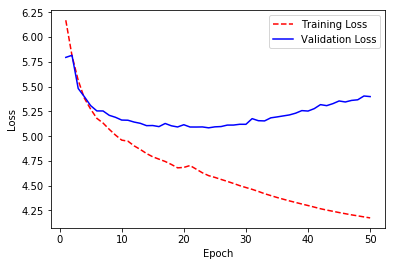

In [21]:
# Get training and validation loss histories
train_loss = []
with open("model_history_attempt5/loss_history_train.txt","r+") as file:
    for line in file:
        train_loss.append(float(line.split('\n')[0]))
        
val_loss = []
with open("model_history_attempt5/loss_history_val.txt","r+") as file:
    for line in file:
        val_loss.append(float(line.split('\n')[0]))
        
# Reference: https://chrisalbon.com/deep_learning/keras/visualize_loss_history/

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [22]:
test_X, test_Y = sentences_to_2darray(sentences_test)
print(test_X.shape)
print(test_Y.shape)

{'COUNTRYMEif', 'language_info', 'theatre', 'defence', 'Spacecenter', 'nbconvert_exporter', 'NATthe', 'catalogue', 'debative', 'Tokenizer', 'IWe', 'ignorings', '#which', 'ameliorations', 'mattox', 'unawed', 'unatoned', 'libertyunites', 'Jehol', '#m', 'Sstates', 'offices#', 'py#', 'reconnoissances', 'ECOSOworking', 'cuentapropistas', 'AIDNew', 'overaction', 'seasonableness', 'precipitancy', 'tfhub', 'iuml', 'Thenceforward', 'HASecretary', 'artificers', 'Wyandots', 'governments###', '#mconvert_by_vocab', 'SE#', 'proper##', 'harbors##', 'Department###', 'Deign', 'ploughed', 'tranquillity', 'reinstitutionalized', 'Tensorflow', '#mappend', 'Aigun', '##Rivers', 'estudiante', 'interoceanic', 'consentaneous', 'Sicilies', 'AIhow', 'MormonChurch', 'LULLABY', 'mutatis', 'Licentious', 'nowise', 'AlmightyGod', 'numpy', 'rinciple', 'Miamies', 'throbbings', 'fieldworks', 'appertains', 'Panamal', 'SIThe', 'causelessly', '###which', 'proportionably', 'ASSEMBLEIt', 'plenarily', 'intrusting', 'tirania', 

In [29]:
model_saved = keras.Sequential()
model_saved.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights_mini],trainable=False))
model_saved.add(LSTM(units = 256, return_sequences = True))
model_saved.add(LSTM(units = 256))
model_saved.add(Dense(vocab_size, activation='softmax'))

model_saved.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [30]:
model_saved.load_weights('model_history_attempt5/checkpoint_model-024.hdf5')

In [31]:
def sample(a, temperature=1.0):
    # helper function to randomly select a word based on probability distribution
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    
    # Reference: https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

# select a test file
file_test_selected = open(f"{files_test_lst[random.randint(0, len(files_test_lst)-1)]}", 'r').read()
# Select a speech from the test file
# randint(a,b) selects from all integers between a and b (inclusive)
# The last speech has zero word, so instead of -1 use -2
gen_speech_index = random.randint(0, len(file_test_selected.split("<speech_sep>"))-1)
# A list of words in the speech
list_words = file_test_selected.split("<speech_sep>")[gen_speech_index].split()
# Select a starting point for the context
start_index = random.randint(0, len(list_words) - x_len - 1)

for diversity in [0.2, 0.5, 1.0, 1.2]:
    print()
    print('----- diversity:', diversity)
    generated = ''
    sentence = list_words[start_index: start_index + x_len]
    generated += ' '.join(sentence)
    print('----- Generating with seed: "' , sentence , '"')
    print()
    sys.stdout.write(generated)
    print()

    for i in range(50):
        x = np.zeros((1, x_len))
        for t, word in enumerate(sentence):
            if word in vocab:
                x[0, t] = word2idx(word)

        # model.predict(x, verbose=0).shape = (1, x_len)
        # model.predict(x, verbose=0)[0].shape = (x_len, )
        preds = model_saved.predict(x, verbose=0)[0]            
        next_index = sample(preds, diversity)
        next_word = idx2word(next_index)
        generated += next_word
        del sentence[0]
        sentence.append(next_word)
        sys.stdout.write(' ')
        sys.stdout.write(next_word)
        sys.stdout.flush()
    print()


----- diversity: 0.2
----- Generating with seed: " ['fourth', ',', 'achieve', 'a', 'lasting', 'political', 'pluralism', 'and', 'respect', 'for', 'human', 'rights', '.', 'Dramatic', 'events', 'have', 'already', 'occurred', 'in', 'Moscow', '.', 'We', 'are', 'impressed', 'by', 'limited', ',', 'but', 'freely', 'contested'] "

fourth , achieve a lasting political pluralism and respect for human rights . Dramatic events have already occurred in Moscow . We are impressed by limited , but freely contested
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

----- diversity: 0.5
----- Generating with seed: " ['fourth', ',', 'achieve', 'a', 'lasting', 'political', 'pluralism', 'and', 'respect', 'for', 'human', 'rights', '.', 'Dramatic', 'events', 'have', 'already', 'occurred', 'in', 'Moscow', '.', 'We', 'are', 'impressed', 'by', 'limited', ',', 'but', 'freely', 'contested'] "

fourth , achieve a lasting political pluralism and respect for human r